## Simulation & Modeling Techniques
### HW3: Modeling & Quadratic Growth


Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import sympy
import pint
UNITS = pint.UnitRegistry()
import modsim
from modsim import*

## 0. Preliminary work

Here, we are going to load the data and prepare it for tasks we will do in this assignment.

The code here are the same used in the last assignment where we modeled population growth.

In [2]:
# Read data
tables = pd.read_html('World_population_estimates.html', header=0, index_col=0, decimal="M")
len(tables)

# Get the 3rd element of the tables
table2 = tables[2]

# Replace new columns names
table2.columns = ['census', 'prb', 'un', 'maddison', 
                  'hyde', 'tanton', 'biraben', 'mj', 
                  'thomlinson', 'durand', 'clark']

# Write data in billion

census = table2.census
un = table2.un

census = census / 1e9
un = un / 1e9


In [3]:
# Calculate elapsed time 

t_0 = get_first_label(census)
t_end = get_last_label(census)
elapsed_time = t_end - t_0

# Calculate growth 

p_0 = get_first_value(census)
p_end = get_last_value(census)
total_growth = p_end - p_0

# Annual growth

annual_growth = total_growth / elapsed_time

## 1. Proportional growth (Chap. 6)

#### Define the system and growth rate

In [4]:
# Set different birth and death rate

## Before 1980:
birth_rate1 = 0.0310
death_rate1 = 0.0120

## After 1980:
birth_rate2 = 0.0370
death_rate2 = 0.0223

# Define growth rates: aplha1, before 1980 and alpha2, after 1980

alpha1 = birth_rate1 - death_rate1
alpha2 = birth_rate2 - death_rate2


# System with alpha1 and alpha2

system = System(t_0 = t_0,
                t_end = t_end,
                p_0 = p_0,
                alpha1 = alpha1,
                alpha2 = alpha2)

#### Write the updated function 

In [5]:
def update_func(pop, t, system):
    """ Compute the population next year.
    pop: current population
    t: current year
    system: system object containing parameters of the model
    returns: population next year depending on which year t falls
    """
    t_cutoff = 1980 # cutoff t
    
    # Set condition to pick a rate depending to where t falls
    
    if t < t_cutoff:
        net_growth = system.alpha1 * pop
        
    else:
        net_growth = system.alpha2 * pop
    
    return pop + net_growth

#### run_simulation function

In [6]:
def run_simulation(system, update_func):
    """Simulate the system using any updtate function
    
    system: System object
    update_func: function that computes the population next year
    
    returns: TimeSeries
    """
    
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        results[t+1] = update_func(results[t], t, system)
    
    return results

#### Test the results

##### Plot the results

In [7]:
def plot_results(census, un, timeseries, title):
    """Plot the estimates and the model.
    
    census: TimeSeries of population estimates
    un: TimeSeries of population estimates
    timeseries: TimeSeries of simulation results
    title: string 
    """
    
    plot(census, ':', label="US Census")
    plot(un, '--', label='UN DESA')
    plot(timeseries, color='green', label='model')
    
    decorate(xlabel='Year',
             ylabel='World population (billion)',
             title=title)

##### Run the simulation

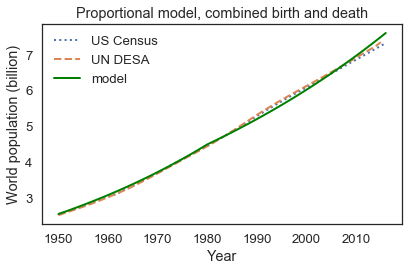

In [8]:
results = run_simulation(system, update_func)
plot_results(census, un, results, 'Proportional model, combined birth and death')

## 2. Quadratic growth (Chap. 7)

We are going to use same functions as defined previously with some modifications adapted to quadratic model.

#### Define parameters

In [9]:
alpha = 0.025
beta = -0.0018

# Max growth rate
r = alpha

# carrying capacity
K = -alpha / beta

#### First parameterization method: Book example

In [10]:
sys1 = System(t_0 = t_0,
              t_end = t_end,
              p_0 = p_0,
              p_end = p_end,
              alpha = alpha,
              beta = beta)

In [11]:
def update_func1(pop, t, sys1):
    
    net_growth = sys1.alpha * pop + sys1.beta * pop**2
    
    return pop + net_growth

#### Second system: New parameterization with carrying capacity

In [12]:
sys2 = System(t_0 = t_0,
              t_end = t_end,
              p_0 = p_0,
              p_end = p_end,
              r = r,
              K = K)

#### Updated function

In [13]:
def update_func2(pop, t, sys2):
    
    p = pop
    
    delta_p = sys2.r*p*(1 - p/sys2.K) # population net growth
    
    return p + delta_p

#### run_simulation & plot: first parameterization

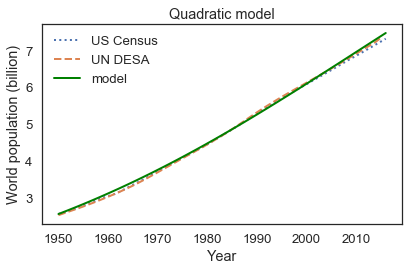

In [14]:
results = run_simulation(sys1, update_func1)
plot_results(census, un, results, 'Quadratic model')

#### run_simulation & plot: second parameterization with carrying capacity

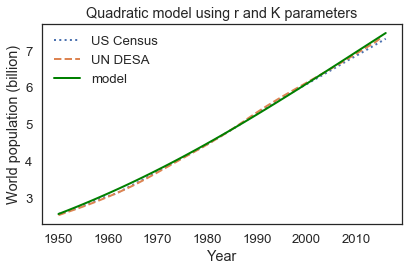

In [15]:
results = run_simulation(sys2, update_func2)
plot_results(census, un, results, 'Quadratic model using r and K parameters')

##### We can confirm that we get the same results from both parameterization methods